### General Hamiltonian construction for qubits being nodes for any adjacency matrix: 


1) Load a graph (npz file) as it will be the adjacency matrix of our graph : 

In [1]:
import numpy as np 
import sys

sys.path.append(r"C:\Users\harsh\quactography")

from quactography.graph.undirected_graph import Graph 
from quactography.adj_matrix.io import load_graph 

# Load graph and see informations from Graph class in quactography library : 

# my_graph = load_graph("rand_graph.npz")
my_graph_class = Graph(np.array([[0,5,1], [5,0,4], [1,4,0]]), 1,0)
print(my_graph_class.starting_nodes)
print(my_graph_class.ending_nodes)
print(my_graph_class.weights)
print(my_graph_class.q_indices)

[0, 0, 1]
[1, 2, 2]
[array([5, 1, 4])]
[0, 1, 2]


#### Cost it takes to go through a given path  (sum of the weights): 

$$
    \sum_{<i,j>} w_{ij} (\frac{I-Z_i}{2}) (\frac{I-Z_j}{2})\\
    \ \frac{1}{4} \sum_{<i,j>} w_{ij} (I - Z_i - Z_j + Z_i Z_j)
    
$$



In [2]:
from qiskit.quantum_info import SparsePauliOp

# First term in Hamiltonian concerning the mandatory cost of given path: 

pauli_weight_first_term = [
            ("I" * my_graph_class.num_nodes, my_graph_class.all_weights_sum / 4)
        ]

# Goes trough a list of starting and ending nodes forming all possible edges in the graph, and according to the formula in markdown previous passage,
# Constructs the Term which includes the cost of the path: 
pos=0
for (node,node2) in zip(my_graph_class.starting_nodes,my_graph_class.ending_nodes):
    
    str1 = (
    "I" * (my_graph_class.num_nodes - 1 - node) + "Z" + "I" * node, 
    -my_graph_class.weights[0][pos]/4 
)
    str2 = (
    "I" * (my_graph_class.num_nodes - 1 - node2) + "Z" + "I" * node2, 
    -my_graph_class.weights[0][pos]/4 
)
    if node< node2:
        str3 = (
            "I" * (my_graph_class.num_nodes - 1 - node2) + "Z" + "I" * (node2-node-1) + "Z" + "I"*node, 
    -my_graph_class.weights[0][pos]/4 
    )
        pauli_weight_first_term.append(str1)
        pauli_weight_first_term.append(str2)
        pauli_weight_first_term.append(str3)
    pos+=1
    
# We must now convert the list of strings containing the Pauli operators to a SparsePauliOp in Qiskit: 

mandatory_cost_h = SparsePauliOp.from_list(pauli_weight_first_term)
mandatory_cost_h

SparsePauliOp(['III', 'IIZ', 'IZI', 'IZZ', 'IIZ', 'ZII', 'ZIZ', 'IZI', 'ZII', 'ZZI'],
              coeffs=[ 2.5 +0.j, -1.25+0.j, -1.25+0.j, -1.25+0.j, -0.25+0.j, -0.25+0.j,
 -0.25+0.j, -1.  +0.j, -1.  +0.j, -1.  +0.j])

#### Departure constraint, makes sure we only have one edge connected to the starting node :

$$
\sum_{i \in D} (\frac{I-Z_D}{2})(\frac{I-Z_i}{2}) - I\\

$$

We notice the first to terms are constants (to be used in code later)

#### Ending constraint, makes sure we only have one edge connected to the ending node :
$$
\sum_{j \in F} (\frac{I-Z_j}{2})(\frac{I-Z_F}{2}) - I\\

$$

In [3]:
departure_nodes = []
finishing_nodes = []

# Constructs the Term of the Hamiltonian which makes sure that there is only one node connected to the starting node (only one path taken from begining)
# Constructs the very similar Term for making sure we also arrive at the ending node with one other intermediate node connected to it:

# Constant terms for Start constraint:
pauli_starting_node_term = [ ("I" * my_graph_class.num_nodes, -1)]

# Constant terms for End constraint:
pauli_end_term = [("I" * my_graph_class.num_nodes, -1)]

for node, node2 in zip(my_graph_class.starting_nodes, my_graph_class.ending_nodes):
    start_node = my_graph_class.starting_node
    end_node = my_graph_class.ending_node

    if node == start_node:
        departure_nodes.append(node2)
    if node2 == start_node:
        departure_nodes.append(node)
    if node == end_node:
        finishing_nodes.append(node2)
    if node2 == end_node:
        finishing_nodes.append(node)

for node in departure_nodes:
    str0 = (
        ("I" * my_graph_class.num_nodes, 0.25)
    ,(
            "I" * (my_graph_class.num_nodes - 1 - my_graph_class.starting_node)
            + "Z"
            + "I" * my_graph_class.starting_node,
            -0.25,
        ),)
    
    pauli_starting_node_term.extend(str0)
    if node > my_graph_class.starting_node:
        str1 = (
            "I" * (my_graph_class.num_nodes - 1 - node)
            + "Z"
            + "I" * (node - my_graph_class.starting_node - 1)
            + "Z"
            + "I" * my_graph_class.starting_node,
            0.25,
        )
        pauli_starting_node_term.append(str1)

    if node < my_graph_class.starting_node:
        str2 = (
            "I" * (my_graph_class.num_nodes - 1 - my_graph_class.starting_node)
            + "Z"
            + "I" * (my_graph_class.starting_node - node - 1)
            + "Z"
            + "I" * node,
            0.25,
        )
        pauli_starting_node_term.append(str2)

    str3 = (
        "I" * (my_graph_class.num_nodes - 1 - node) + "Z" + "I" * node,
        -0.25,
    )
    pauli_starting_node_term.append(str3)



for node in finishing_nodes:

    if node > my_graph_class.ending_node:
        str4 = (
            "I" * (my_graph_class.num_nodes - 1 - node)
            + "Z"
            + "I" * (node - my_graph_class.ending_node - 1)
            + "Z"
            + "I" * my_graph_class.ending_node,
            0.25,
        )
        pauli_end_term.append(str4)

    if node < my_graph_class.ending_node:
        str5 = (
            "I" * (my_graph_class.num_nodes - 1 - my_graph_class.ending_node)
            + "Z"
            + "I" * (my_graph_class.ending_node - node - 1)
            + "Z"
            + "I" * node,
            0.25,
        )
        pauli_end_term.append(str5)

    str6 = (
        "I" * (my_graph_class.num_nodes - 1 - node) + "Z" + "I" * node,
        -0.25,
    )
    pauli_end_term.append(str6)

    

    str7 = (
        ("I" * my_graph_class.num_nodes, 0.25),
        (
            "I" * (my_graph_class.num_nodes - 1 - my_graph_class.ending_node)
            + "Z"
            + "I" * my_graph_class.ending_node,
            -0.25,
        ),
    )

    pauli_end_term.extend(str7)
   

print(pauli_starting_node_term)    
print(pauli_end_term) 

print('D : ',departure_nodes)
print('F : ',finishing_nodes)

start_node_constraint_cost_h = SparsePauliOp.from_list(pauli_starting_node_term)    
print(start_node_constraint_cost_h)

ending_node_constraint_cost_h = SparsePauliOp.from_list(pauli_end_term) 
print(ending_node_constraint_cost_h)

[('III', -1), ('III', 0.25), ('IZI', -0.25), ('IZZ', 0.25), ('IIZ', -0.25), ('III', 0.25), ('IZI', -0.25), ('ZZI', 0.25), ('ZII', -0.25)]
[('III', -1), ('IZZ', 0.25), ('IZI', -0.25), ('III', 0.25), ('IIZ', -0.25), ('ZIZ', 0.25), ('ZII', -0.25), ('III', 0.25), ('IIZ', -0.25)]
D :  [0, 2]
F :  [1, 2]
SparsePauliOp(['III', 'III', 'IZI', 'IZZ', 'IIZ', 'III', 'IZI', 'ZZI', 'ZII'],
              coeffs=[-1.  +0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j,
 -0.25+0.j,  0.25+0.j, -0.25+0.j])
SparsePauliOp(['III', 'IZZ', 'IZI', 'III', 'IIZ', 'ZIZ', 'ZII', 'III', 'IIZ'],
              coeffs=[-1.  +0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j,
 -0.25+0.j,  0.25+0.j, -0.25+0.j])


#### Constraint on intermediate nodes (pair number of edges connected to them):  

$$
\sum_{k \in I_k} \left( \left(\prod_{<k,j>} Z_j\right)-I\right)
$$

We should then keep in mind that we want to formulate the Hamiltonian in a QUBO fashion. For that, our constraints must be positive whereas the mandatory cost is negative. 
Then, the total Hamiltonian should be: 

$$
 - \sum_{<i,j>} w_{ij} (\frac{I-Z_i}{2}) (\frac{I-Z_j}{2}) +  \alpha \left( \left(\sum_{i \in D} (\frac{I-Z_D}{2})(\frac{I-Z_i}{2}) - I\right)^2 + \left(\sum_{j \in F} (\frac{I-Z_j}{2})(\frac{I-Z_F}{2}) - I\right)^2 + \sum_{k \in I_k} \left( \left(\prod_{<k,j>} Z_j\right)-I \right)^2   \right)
$$

We notice that the last term is not all squared, the sum is left outside the squared factor: 

In [4]:
# List of ["I" * num_nodes], then replace j element in list by Z (nodes connected to intermediate node k) 

initial_int_term = ["I"] * my_graph_class.num_nodes

print(my_graph_class.starting_nodes)
print(my_graph_class.ending_nodes)
print(my_graph_class.starting_node)
print(my_graph_class.ending_node)


# Set an empty dictionary to store the intermediate nodes connected to which other node in the graph:      
node_connected = {}
for node,node2 in zip(my_graph_class.starting_nodes, my_graph_class.ending_nodes):
    if node != my_graph_class.starting_node and node != my_graph_class.ending_node:
        if node not in node_connected:
            node_connected[node] = [node2]
        else:
            node_connected[node].append(node2)
    if node2 != my_graph_class.starting_node and node2 != my_graph_class.ending_node:
        if node2 not in node_connected:
            node_connected[node2] = [node]
        else:
            node_connected[node2].append(node)
node_connected

[0, 0, 1]
[1, 2, 2]
1
0


{2: [0, 1]}

We now have a dictionnary of intermediate nodes in graph with the nodes it is connected to. 
What is left to do is to Replace in the initial identity term, the corresponding qubits indices to Z instead of I:

In [5]:
# Create the right number of terms for every intermediate node: 

initial_int_term_list =[ initial_int_term] * len(node_connected)
# initial_int_term_list

# Replace the position of the list which are values in the dictionary by Z:
for pos, node_name in enumerate(node_connected):
    for node in node_connected[node_name]:
        initial_int_term_list[pos] = list(initial_int_term_list[pos])
        initial_int_term_list[pos][node] = "Z"
        initial_int_term_list[pos] = "".join(initial_int_term_list[pos])
        initial_int_term_list[pos] = initial_int_term_list[pos]
        # reverse the string to have the correct order of the qubits
        initial_int_term_list[pos] = initial_int_term_list[pos][::-1]
    
print(initial_int_term_list)

# Now that we have the  product terms, we must add the substraction of the identity operator to each term, elevate each of them to the square, then sum them as a SparsePauliOp:
for i in range(len(initial_int_term_list)):
    initial_int_term_list[i] = (initial_int_term_list[i], 1)
    initial_int_term_list[i] = [initial_int_term_list[i],(("I" * my_graph_class.num_nodes, -1))]
list_with_identity = initial_int_term_list

print('identity : ',list_with_identity)

# Create a Pauli Operator with the terms in the list:
for i in range(len(list_with_identity)):
    list_with_identity[i] = SparsePauliOp.from_list(list_with_identity[i])

print('Pauli Operators of list elements : ',list_with_identity)

# Square each term :
for i in range(len(list_with_identity)):
    list_with_identity[i] = list_with_identity[i] @ list_with_identity[i]
print('Squared each term: ',list_with_identity)

# Sum all the terms:
initial_int_term_h = sum(list_with_identity)
sum_intermediate_cost_h_terms = initial_int_term_h
sum_intermediate_cost_h_terms

['ZZI']
identity :  [[('ZZI', 1), ('III', -1)]]
Pauli Operators of list elements :  [SparsePauliOp(['ZZI', 'III'],
              coeffs=[ 1.+0.j, -1.+0.j])]
Squared each term:  [SparsePauliOp(['III', 'ZZI', 'ZZI', 'III'],
              coeffs=[ 1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j])]


SparsePauliOp(['III', 'ZZI', 'ZZI', 'III'],
              coeffs=[ 1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j])

In [9]:
from quactography.graph.undirected_graph import Graph
from quactography.adj_matrix.io import load_graph
from quactography.hamiltonian.hamiltonian_qubit_node import Hamiltonian_qubit_node
import numpy as np
import sys

sys.path.append(r"C:\Users\harsh\quactography")

from quactography.adj_matrix.io import save_graph

my_graph_class = Graph(np.array([[0,5,1], [5,0,4], [1,4,0]]), 1,0)
print(my_graph_class.starting_nodes)
print(my_graph_class.ending_nodes)
print(my_graph_class.weights)
print(my_graph_class.q_indices)

# Test mandatory_cost
h = Hamiltonian_qubit_node(my_graph_class, 1)
print(h.mandatory_c)

# # Test starting_ending_node_cost
# print(h.starting_node_c)  
# print(h.ending_node_c)  

# # Test intermediate_cost 
# print(h.hint_c)  

print('total :', h.total_hamiltonian.simplify())
print(h.exact_cost)
print(h.exact_path)
from quactography.hamiltonian.validate import print_hamiltonian_circuit

print_hamiltonian_circuit(h.total_hamiltonian, ["110"])
print_hamiltonian_circuit(h.mandatory_c, ["110"])
print_hamiltonian_circuit(h.starting_node_c, ["110"])
print_hamiltonian_circuit(h.ending_node_c, ["110"])
print_hamiltonian_circuit(h.hint_c, ["110"])

[0, 0, 1]
[1, 2, 2]
[array([5, 1, 4])]
[0, 1, 2]
SparsePauliOp(['III', 'IIZ', 'IZI', 'IZZ', 'IIZ', 'ZII', 'ZIZ', 'IZI', 'ZII', 'ZZI'],
              coeffs=[ 2.5 +0.j, -1.25+0.j, -1.25+0.j, -1.25+0.j, -0.25+0.j, -0.25+0.j,
 -0.25+0.j, -1.  +0.j, -1.  +0.j, -1.  +0.j])
total : SparsePauliOp(['III', 'IIZ', 'IZI', 'IZZ', 'ZII', 'ZIZ', 'ZZI', 'ZZZ'],
              coeffs=[ 1.  +0.j,  1.75+0.j,  2.5 +0.j,  1.25+0.j,  1.25+0.j,  0.5 +0.j,
 -0.75+0.j, -0.5 +0.j])
[-4.+0.j]
['110']
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
           
 Cost for path (classical read -> left=q0) 110  :  -1.0
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
           
 Cost for path (classical read -> left=q0) 110  :  5.0
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
           
 Cost for path (classical read -> left=q0) 110  :  0.0
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
           
 Cost for path (classical read -> left=q0) 

#### How to test the code with custom graph using the quactography library: 

In [7]:
# import numpy as np 
# import sys
# sys.path.append(r"C:\Users\harsh\quactography")

# from quactography.adj_matrix.io import save_graph 

# mat = np.array([[0,1,1,0],[1,0,1,5],[1,1,0,6], [0,5,6,0]])

# # This is the given format you should use to save the graph, for mat: 
# save_graph(mat,np.array([0,1,2,3]),np.array([4,4]),"rand_graph.npz")


Here, we want to visualize what different possible paths look like, using tools like networkx in order to get a better understanding of bad cases and thus, find constraints that are suitable. When right clauses are found, the next objective is to transform the classical equations in the form of Pauli opertors terms before translating the problem in QUBO form ,or another method could be used. 

DiGraph with 4 nodes and 12 edges


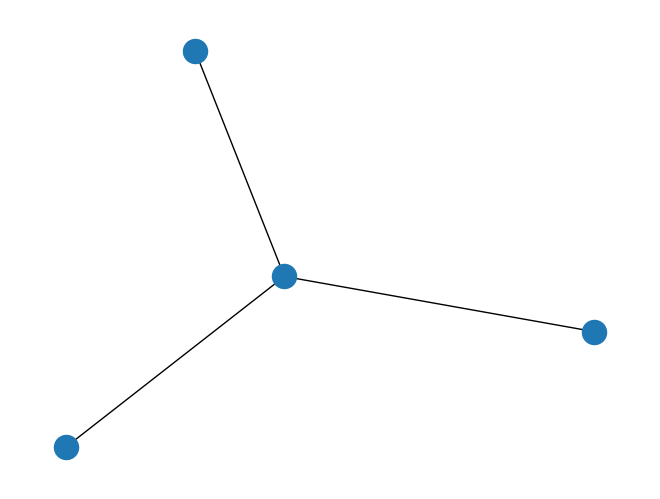

[[0 1 1 1]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]


In [113]:
# Paths visualisation tool with networkx for nodes: 
# Before implementing the desired test, let's review the basics of Networkx: 

# First import library:
import networkx as nx 
import matplotlib.pyplot as plt 

# Create a graph instance, with Graph method: 
G = nx.Graph()

# Add nodes to the graph (could be the column names of ajacency matrix): 
# Here, it is possible to add a node composed of nodes (nbunch), see documentation if desired. 
# The nbunch advantage is to have a graph representation of an object that is different than simple nodes
# but can be functions, files etc. 
# G.add_nodes_from([0,1,2,3])
G.add_node(1, role = 's')
G.add_node(0, role='i')
G.add_node(2, role='i')
G.add_node(3, role='i')
G.add_node(1, role = 'f')

# print(G.nodes(data=True))

# If we want to add all possible ways to get a path from start node to finish node, 
# We must make a function to test them out: 

# TODO : function to trace all possible routes. 

# Add all edges: 
G.add_edges_from([(0,1), (0,2), (0,3), (1,2), (1,3), (2,3) ])

# It is also possible to trace a directed graph : 

dG = nx.DiGraph(G)
print(dG)

# Coloring edges for example edge(0,1):
G[0][1]['color'] = 'blue'

# Using a stochastic graph generator, e.g.
#  >>> er=nx.erdos_renyi_graph(100,0.15)
#  >>> ws=nx.watts_strogatz_graph(30,3,0.1)
#  >>> ba=nx.barabasi_albert_graph(100,5)
#  >>> red=nx.random_lobster(100,0.9,0.9)

#  Reading a graph stored in a file using common graph formats, such as edge lists, adjacency lists, GML,
#  GraphML, pickle, LEDA and others.
#  >>> nx.write_gml(red,"path.to.file")
#  >>> mygraph=nx.read_gml("path.to.file")

# Useful for datas resembling: 
G= nx.watts_strogatz_graph(30, 3, 0.1)

# Useful for degree test: 
G = nx.random_lobster(5, 0.5, 0.3)
nx.draw(G)
plt.show()
print(nx.adjacency_matrix(G).todense())